# Autism Spectrum Disorder (ASD) Screening

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel, SelectKBest, mutual_info_regression, chi2
import numpy as np
from operator import itemgetter

## 1. Load Data

Autism_Data.arff – For this .arff format, I converted it into csv for better readability. And loaded it to a pandas dataframe.

In [239]:
import pandas as pd
from scipy.io import arff

# Load the ARFF file
data, meta = arff.loadarff('/Users/kavanamanvi/Desktop/AML/FinalProject/autism/Autism-Adult-Data.arff')

# Convert to Pandas DataFrame
df = pd.DataFrame(data)

# Decode byte-string columns if necessary
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Save as CSV
df.to_csv('/Users/kavanamanvi/Desktop/AML/FinalProject/autism/Autism-Adult-Data.csv', index=False)

print("ARFF file successfully converted to CSV!")


ARFF file successfully converted to CSV!


In [241]:
df = pd.read_csv("/Users/kavanamanvi/Desktop/AML/FinalProject/autism/Autism-Adult-Data.csv")

In [243]:
df["Class/ASD"] = df["Class/ASD"].replace({"YES": 1, "NO": 0}).astype(int)

In [247]:
df["Class/ASD"].value_counts()

Class/ASD
0    515
1    189
Name: count, dtype: int64

In [245]:
pd.set_option('display.max_columns', None)
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,26.0,f,White-European,no,no,United States,no,6.0,18 and more,Self,0
1,1,1,0,1,0,0,0,1,0,1,24.0,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,0
2,1,1,0,1,1,0,1,1,1,1,27.0,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,1
3,1,1,0,1,0,0,1,1,0,1,35.0,f,White-European,no,yes,United States,no,6.0,18 and more,Self,0
4,1,0,0,0,0,0,0,1,0,0,40.0,f,?,no,no,Egypt,no,2.0,18 and more,?,0


## 2. Data Cleaning

I corrected some spelling errors and found many missing ethnicity values. If the missing values were numerical, like age, I could have easily imputed them using the mean or mode. However, since ethnicity is a categorical variable, I decided to remove all rows with missing values.

In [213]:
df.rename(columns={"jundice": "jaundice"}, inplace=True)

In [215]:
df.rename(columns={"contry_of_res": "country"}, inplace=True)

In [217]:
#since this is an adult autism dataset, removing it coz all people are 18+
df= df.drop(columns=['age_desc'], errors='ignore')

In [219]:
# Replace NaN values in 'age' with the mean age
df['age'].fillna(df['age'].mode(), inplace=True)

In [221]:
df.isna().sum()

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                2
gender             0
ethnicity          0
jaundice           0
austim             0
country            0
used_app_before    0
result             0
relation           0
Class/ASD          0
dtype: int64

In [166]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
A1_Score,704.0,NaN,NaN,NaN,0.721591,0.448535,0.0,0.0,1.0,1.0,1.0
A2_Score,704.0,NaN,NaN,NaN,0.453125,0.498152,0.0,0.0,0.0,1.0,1.0
A3_Score,704.0,NaN,NaN,NaN,0.457386,0.498535,0.0,0.0,0.0,1.0,1.0
A4_Score,704.0,NaN,NaN,NaN,0.495739,0.500337,0.0,0.0,0.0,1.0,1.0
A5_Score,704.0,NaN,NaN,NaN,0.49858,0.500353,0.0,0.0,0.0,1.0,1.0
A6_Score,704.0,NaN,NaN,NaN,0.284091,0.451301,0.0,0.0,0.0,1.0,1.0
A7_Score,704.0,NaN,NaN,NaN,0.417614,0.493516,0.0,0.0,0.0,1.0,1.0
A8_Score,704.0,NaN,NaN,NaN,0.649148,0.477576,0.0,0.0,1.0,1.0,1.0
A9_Score,704.0,NaN,NaN,NaN,0.323864,0.468281,0.0,0.0,0.0,1.0,1.0
A10_Score,704.0,NaN,NaN,NaN,0.573864,0.494866,0.0,0.0,1.0,1.0,1.0


In [17]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,country,used_app_before,result,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,26.0,f,White-European,no,no,United States,no,6.0,Self,0
1,1,1,0,1,0,0,0,1,0,1,24.0,m,Latino,no,yes,Brazil,no,5.0,Self,0
2,1,1,0,1,1,0,1,1,1,1,27.0,m,Latino,yes,yes,Spain,no,8.0,Parent,1
3,1,1,0,1,0,0,1,1,0,1,35.0,f,White-European,no,yes,United States,no,6.0,Self,0
4,1,0,0,0,0,0,0,1,0,0,40.0,f,?,no,no,Egypt,no,2.0,?,0


In [168]:
num_rows, num_cols = df.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 704
Number of columns: 20


## 3. Exploratory analysis

I created some visualizations to see and understand all the features in the dataset.

<Figure size 1200x600 with 0 Axes>

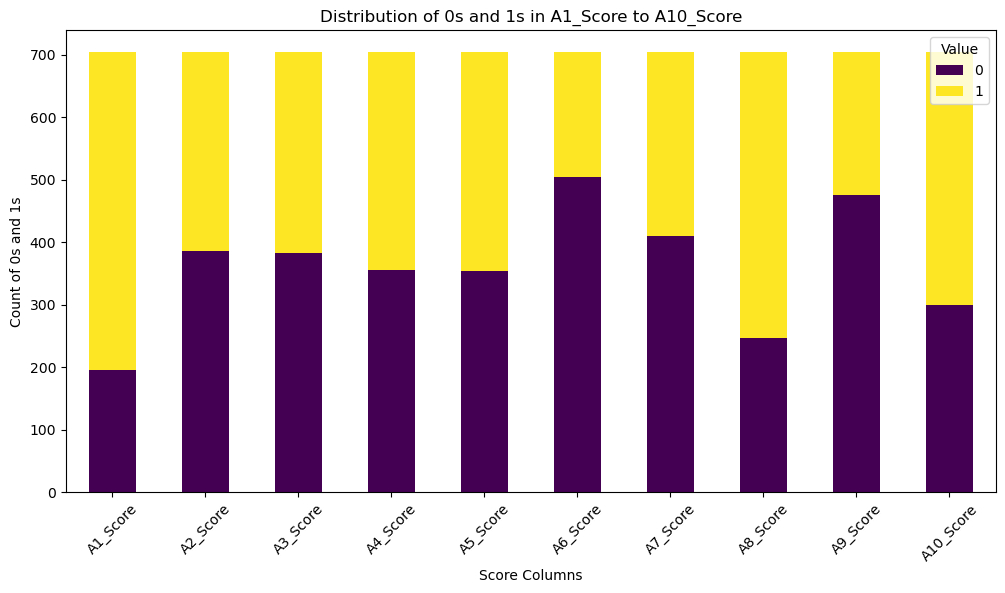

In [21]:
score_columns = [f"A{i}_Score" for i in range(1, 11)]
plt.figure(figsize=(12, 6))
score_counts = {col: df[col].value_counts().sort_index() for col in score_columns}
score_counts_df = pd.DataFrame(score_counts).T  # Transpose for better plotting
score_counts_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.xlabel("Score Columns")
plt.ylabel("Count of 0s and 1s")
plt.title("Distribution of 0s and 1s in A1_Score to A10_Score")
plt.legend(title="Value")
plt.xticks(rotation=45)
plt.show()

In the Autism Spectrum Disorder (ASD) dataset for adults, the **A_1 to A_10** features correspond to the ten behavioral screening questions derived from the **AQ-10 (Autism Spectrum Quotient - 10 items)** questionnaire. These questions assess various traits and behaviors associated with ASD, focusing on social interaction, communication, and repetitive behaviors. Below is the general interpretation of these questions:  

1. **A_1** – Difficulty noticing small details in surroundings  
2. **A_2** – Struggles with social interactions and making friends  
3. **A_3** – Finds it challenging to understand others' emotions  
4. **A_4** – Prefers routine and feels distressed when routines change  
5. **A_5** – Strong focus on specific interests or hobbies  
6. **A_6** – Finds it difficult to engage in conversations or follow social cues  
7. **A_7** – Notices patterns or details that others may overlook  
8. **A_8** – Prefers solitude over social gatherings  
9. **A_9** – Feels overwhelmed in noisy or crowded environments  
10. **A_10** – Has difficulty adapting to unexpected changes  

These questions are typically answered on a **binary scale (Yes/No or 1/0)**

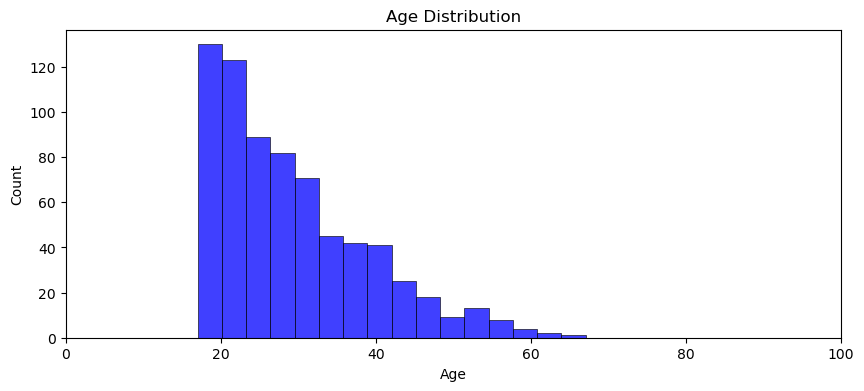

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Age Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df["age"], color="blue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.xlim(0, 100)  # Set x-axis range from 0 to 100
plt.show()

The age histogram is right skwed. 

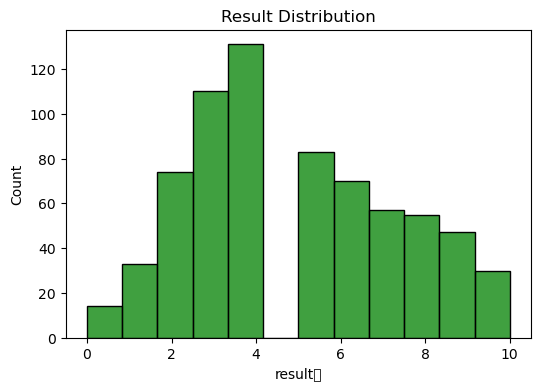

In [25]:
# Plot Age Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df["result"],  color="green")
plt.xlabel("result	")
plt.ylabel("Count")
plt.title("Result Distribution")
plt.show()

Result histogram is normally distributed

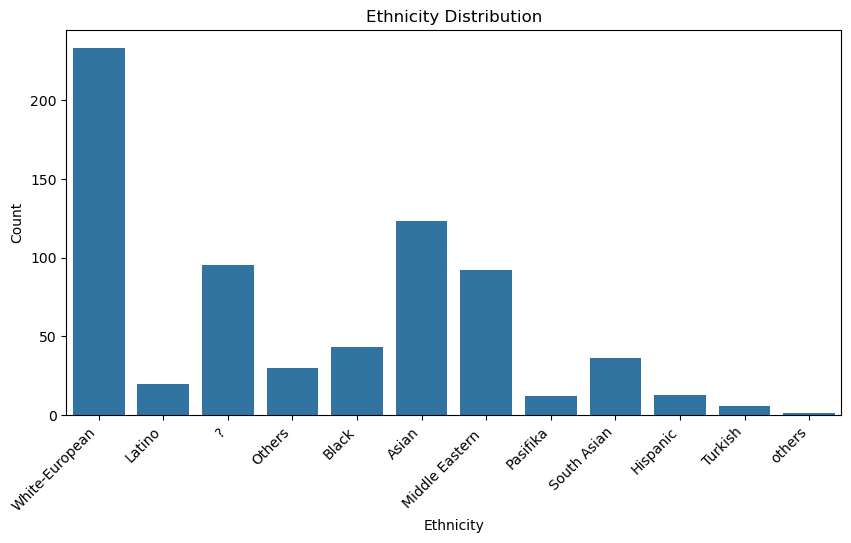

In [27]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df["ethnicity"]) 
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.title("Ethnicity Distribution")
plt.show()

out of 11 ethniticities, most of the population in this data set comes under white-european.

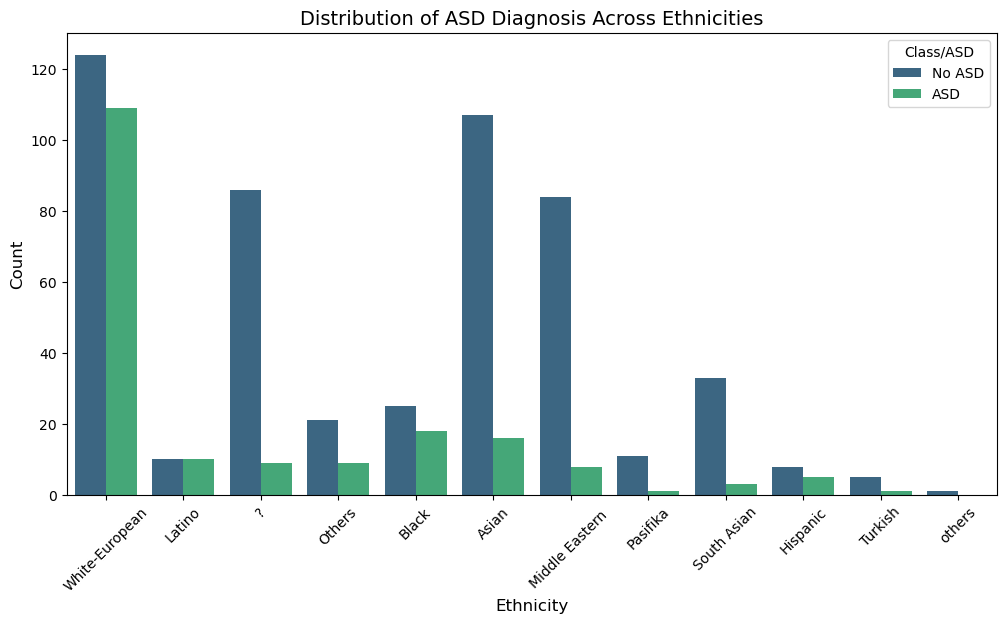

In [29]:
plt.figure(figsize=(12, 6))

sns.countplot(data=df, x='ethnicity', hue='Class/ASD', palette='viridis')

# Labeling
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.xlabel("Ethnicity", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of ASD Diagnosis Across Ethnicities", fontsize=14)
plt.legend(title="Class/ASD", labels=["No ASD", "ASD"])

# Show the plot
plt.show()

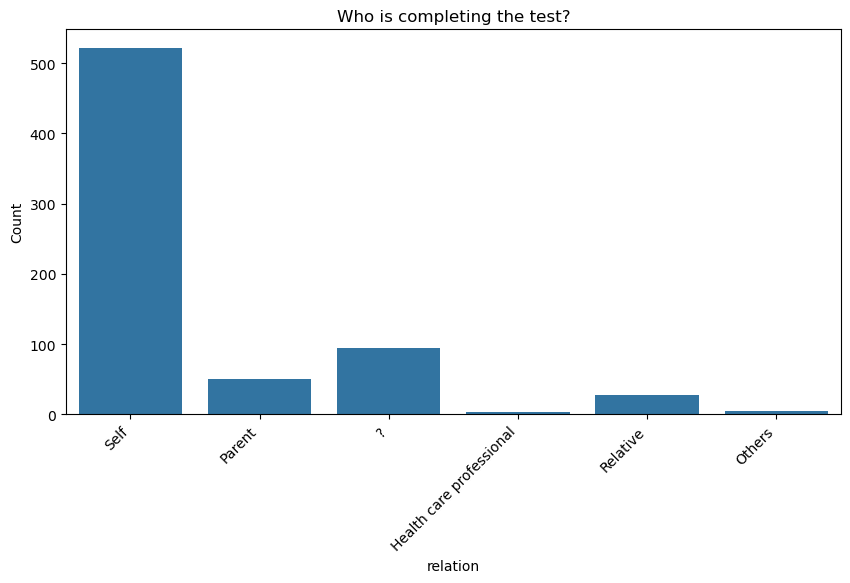

In [31]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df["relation"]) 
plt.xticks(rotation=45, ha="right")
plt.xlabel("relation")
plt.ylabel("Count")
plt.title("Who is completing the test?")
plt.show()

looks like the test was taken by self more than others

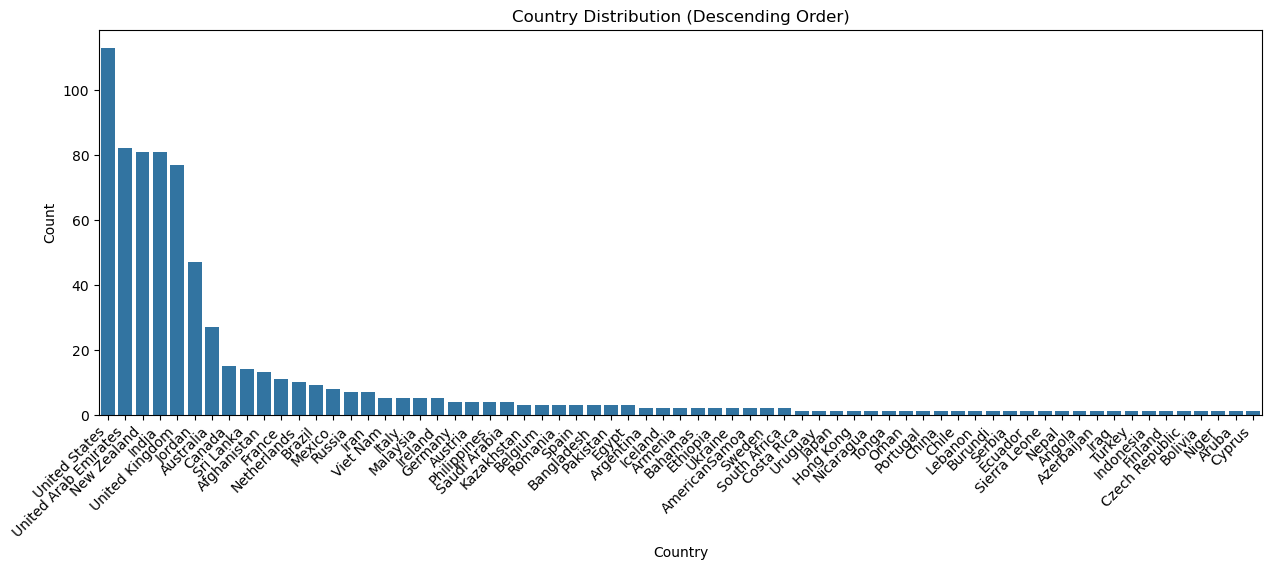

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each country and sort in descending order
country_counts = df["country"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 5))
sns.countplot(x=pd.Categorical(df["country"], categories=country_counts.index, ordered=True), order=country_counts.index)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Country Distribution (Descending Order)")
plt.show()


I arranged all the values in descending order to see which countries my dataset population belongs to.

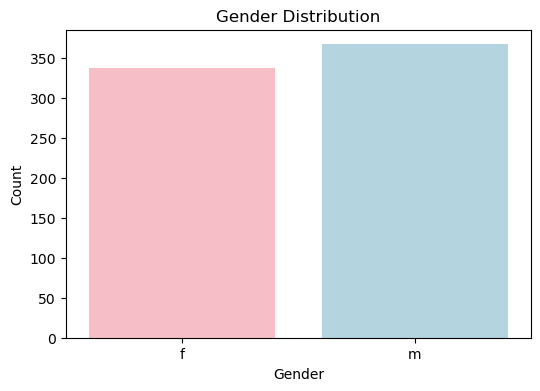

In [35]:
df["gender"] = df["gender"].str.lower()  # Normalize casing
custom_palette = {"f": "lightpink", "m": "lightblue"}
plt.figure(figsize=(6, 4))
sns.countplot(x="gender", data=df, hue="gender", palette=custom_palette, legend=False)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")
plt.show()

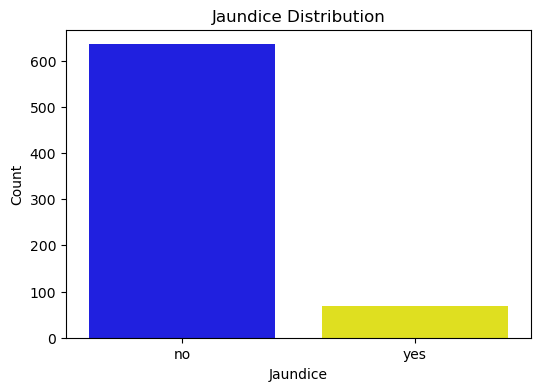

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'jaundice' column values are in lowercase
df["jaundice"] = df["jaundice"].str.lower()

# Define custom colors for the categories
custom_palette = {"no": "blue", "yes": "yellow"}

plt.figure(figsize=(6, 4))

# Create the count plot without hue
sns.countplot(x="jaundice", data=df, palette=custom_palette)

# Labels and title
plt.xlabel("Jaundice")
plt.ylabel("Count")
plt.title("Jaundice Distribution")

# Show the plot
plt.show()


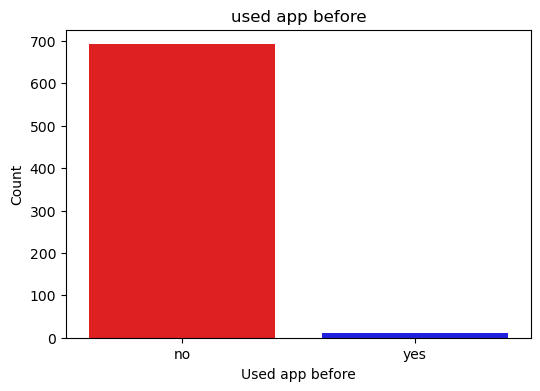

In [37]:
# Define custom colors for the categories
custom_palette = {"no": "red", "yes": "blue"}

plt.figure(figsize=(6, 4))

# Create the count plot without hue
sns.countplot(x="used_app_before", data=df, palette=custom_palette)

# Labels and title
plt.xlabel("Used app before")
plt.ylabel("Count")
plt.title("used app before")

# Show the plot
plt.show()


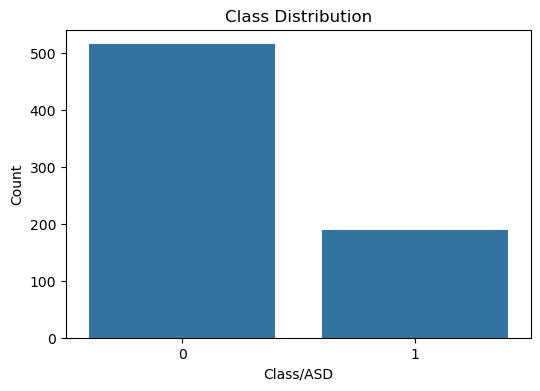

In [38]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Class/ASD"])

# Labels and title
plt.xlabel("Class/ASD")
plt.ylabel("Count")
plt.title("Class Distribution")

# Show the plot
plt.show()

In [170]:
df['Class/ASD'].value_counts()

Class/ASD
0    515
1    189
Name: count, dtype: int64

Class is imbalanced. We have 429 cases with no autism and 180 cases with ASD. So I will think of ways to mitigate this issue in the future steps below. It's kinda like the cancer set discussion we had in 3rd class. I should consider AUC, sensitivity and specificity as my metric rather than soley relying on accuracy. I will also look into my model's confusion matrix.

## 4. Data Preprocessing

In [223]:
df['ethnicity'] = df['ethnicity'].replace('?', np.nan)

In [137]:
df['Class/ASD'].value_counts()

Class/ASD
0    429
1    180
Name: count, dtype: int64

In [225]:
df = df.dropna()

# Calculate the most frequent ethnicity for each country and store it in a dictionary
most_frequent_ethnicity = df.groupby('country')['ethnicity'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').to_dict()
# Display the dictionary
print(most_frequent_ethnicity)

# Replace '?' in df['ethnicity'] with the most frequent ethnicity for each country
df['ethnicity'] = df.apply(
    lambda row: most_frequent_ethnicity[row['country']] if row['ethnicity'] == '?' else row['ethnicity'], axis=1
)


Normalization, covert yes/no, male/female to 0/1

In [227]:
df.replace({'yes': 1, 'no': 0}, inplace=True)
df.replace({'m': 1, 'f': 0}, inplace=True)

In [231]:
df['Age_Binned'] = pd.qcut(df['age'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df = df.drop(columns=['Age'])

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,country,used_app_before,result,relation,Class/ASD,Age_Binned
0,1,1,1,1,0,0,1,1,0,0,26.0,0,White-European,0,0,United States,0,6.0,Self,0,Q3
1,1,1,0,1,0,0,0,1,0,1,24.0,1,Latino,0,1,Brazil,0,5.0,Self,0,Q2
2,1,1,0,1,1,0,1,1,1,1,27.0,1,Latino,1,1,Spain,0,8.0,Parent,1,Q3
3,1,1,0,1,0,0,1,1,0,1,35.0,0,White-European,0,1,United States,0,6.0,Self,0,Q4
5,1,1,1,1,1,0,1,1,1,1,36.0,1,Others,1,0,United States,0,9.0,Self,1,Q4


In [229]:
df_normalized['Age_Binned'] = pd.qcut(df_normalized['age'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# Check the result
df_normalized.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,austim,used_app_before,result,Class/ASD,country_Afghanistan,country_AmericanSamoa,country_Angola,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Bahamas,country_Bangladesh,country_Belgium,country_Bolivia,country_Brazil,country_Burundi,country_Canada,country_Chile,country_China,country_Costa Rica,country_Cyprus,country_Czech Republic,country_Ecuador,country_Egypt,country_Ethiopia,country_Finland,country_France,country_Germany,country_Iceland,country_India,country_Indonesia,country_Iran,country_Ireland,country_Italy,country_Jordan,country_Malaysia,country_Mexico,country_Nepal,country_Netherlands,country_New Zealand,country_Nicaragua,country_Niger,country_Oman,country_Pakistan,country_Philippines,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Sierra Leone,country_South Africa,country_Spain,country_Sri Lanka,country_Sweden,country_Tonga,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Viet Nam,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others,Age_Binned
0,1,1,1,1,0,0,1,1,0,0,0.024590,0,0,0,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Q3
1,1,1,0,1,0,0,0,1,0,1,0.019126,1,0,1,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,Q2
2,1,1,0,1,1,0,1,1,1,1,0.027322,1,1,1,0,0.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,Q3
3,1,1,0,1,0,0,1,1,0,1,0.049180,0,0,1,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Q4
5,1,1,1,1,1,0,1,1,1,1,0.051913,1,1,0,0,0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Q4


In [131]:
# Step 1: Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=['country', 'relation', 'ethnicity'])

In [133]:
# Step 2: Convert all boolean columns to int (1 and 0)
bool_columns = df_encoded.select_dtypes(include=bool).columns
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

In [50]:
df_encoded.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,austim,used_app_before,result,Class/ASD,country_Afghanistan,country_AmericanSamoa,country_Angola,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Bahamas,country_Bangladesh,country_Belgium,country_Bolivia,country_Brazil,country_Burundi,country_Canada,country_Chile,country_China,country_Costa Rica,country_Cyprus,country_Czech Republic,country_Ecuador,country_Egypt,country_Ethiopia,country_Finland,country_France,country_Germany,country_Iceland,country_India,country_Indonesia,country_Iran,country_Ireland,country_Italy,country_Jordan,country_Malaysia,country_Mexico,country_Nepal,country_Netherlands,country_New Zealand,country_Nicaragua,country_Niger,country_Oman,country_Pakistan,country_Philippines,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Sierra Leone,country_South Africa,country_Spain,country_Sri Lanka,country_Sweden,country_Tonga,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Viet Nam,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others
0,1,1,1,1,0,0,1,1,0,0,26.0,0,0,0,0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,1,0,1,0,0,0,1,0,1,24.0,1,0,1,0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1,1,0,1,1,0,1,1,1,1,27.0,1,1,1,0,8.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,1,0,1,0,0,1,1,0,1,35.0,0,0,1,0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
5,1,1,1,1,1,0,1,1,1,1,36.0,1,1,0,0,9.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [51]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Create a copy of df_encoded to avoid modifying the original
df_normalized = df_encoded.copy()

# Normalize the 'age' column
df_normalized['age'] = scaler.fit_transform(df_normalized[['age']])
df_normalized['result'] = scaler.fit_transform(df_normalized[['result']])

In [52]:
df_normalized.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,austim,used_app_before,result,Class/ASD,country_Afghanistan,country_AmericanSamoa,country_Angola,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Bahamas,country_Bangladesh,country_Belgium,country_Bolivia,country_Brazil,country_Burundi,country_Canada,country_Chile,country_China,country_Costa Rica,country_Cyprus,country_Czech Republic,country_Ecuador,country_Egypt,country_Ethiopia,country_Finland,country_France,country_Germany,country_Iceland,country_India,country_Indonesia,country_Iran,country_Ireland,country_Italy,country_Jordan,country_Malaysia,country_Mexico,country_Nepal,country_Netherlands,country_New Zealand,country_Nicaragua,country_Niger,country_Oman,country_Pakistan,country_Philippines,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Sierra Leone,country_South Africa,country_Spain,country_Sri Lanka,country_Sweden,country_Tonga,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Viet Nam,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others
0,1,1,1,1,0,0,1,1,0,0,0.024590,0,0,0,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,1,0,1,0,0,0,1,0,1,0.019126,1,0,1,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1,1,0,1,1,0,1,1,1,1,0.027322,1,1,1,0,0.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,1,0,1,0,0,1,1,0,1,0.049180,0,0,1,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
5,1,1,1,1,1,0,1,1,1,1,0.051913,1,1,0,0,0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [135]:
num_rows, num_cols = df.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 609
Number of columns: 20


## 5. Feature selection

In [55]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def apply_feature_selection(X, y, fs_type):
    """
    Applies feature selection to normalized data based on specified method.
    
    Parameters:
    X (pd.DataFrame): Normalized feature matrix
    y (pd.Series): Target variable
    fs_type (int): 0=All features, 1=MI, 2=RFE, 3=CMIM+RF
    
    Returns:
    pd.DataFrame: Selected feature subset
    """
    
    if fs_type == 0:
        return X  # Return all features
    
    elif fs_type == 1:
        # Mutual Information (MI)
        selector = SelectKBest(mutual_info_classif, k=10)  # Top 50% features
        return pd.DataFrame(selector.fit_transform(X, y), 
                          columns=X.columns[selector.get_support()])
    
    elif fs_type == 2:
        # Recursive Feature Elimination (RFE)
        estimator = SVC(kernel="linear")
        selector = RFECV(estimator, cv=5, scoring='accuracy')
        return pd.DataFrame(selector.fit_transform(X, y), 
                          columns=X.columns[selector.get_support()])
    
    elif fs_type == 3:
        # CMIM-inspired RF-based Selection
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X, y)
        cmim_mask = rf.feature_importances_ > np.median(rf.feature_importances_)
        return X.loc[:, cmim_mask]
    
    else:
        raise ValueError("Invalid fs_type (0-3 only)")

# Usage example:
# X_selected = apply_feature_selection(X_normalized, y_target, fs_type=1)


## 6 and 7 Training Models and Evaluation

In [57]:
y_normalized = df_normalized['Class/ASD']  # Target variable
X_normalized = df_normalized.drop(columns=['Class/ASD'])  # Features

In [143]:
df_encoded.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,austim,used_app_before,result,Class/ASD,country_Afghanistan,country_AmericanSamoa,country_Angola,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Bahamas,country_Bangladesh,country_Belgium,country_Bolivia,country_Brazil,country_Burundi,country_Canada,country_Chile,country_China,country_Costa Rica,country_Cyprus,country_Czech Republic,country_Ecuador,country_Egypt,country_Ethiopia,country_Finland,country_France,country_Germany,country_Iceland,country_India,country_Indonesia,country_Iran,country_Ireland,country_Italy,country_Jordan,country_Malaysia,country_Mexico,country_Nepal,country_Netherlands,country_New Zealand,country_Nicaragua,country_Niger,country_Oman,country_Pakistan,country_Philippines,country_Portugal,country_Romania,country_Russia,country_Saudi Arabia,country_Serbia,country_Sierra Leone,country_South Africa,country_Spain,country_Sri Lanka,country_Sweden,country_Tonga,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Viet Nam,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others
0,1,1,1,1,0,0,1,1,0,0,26.0,0,0,0,0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,1,0,1,0,0,0,1,0,1,24.0,1,0,1,0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1,1,0,1,1,0,1,1,1,1,27.0,1,1,1,0,8.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,1,0,1,0,0,1,1,0,1,35.0,0,0,1,0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
5,1,1,1,1,1,0,1,1,1,1,36.0,1,1,0,0,9.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [58]:
y_encoded = df_encoded['Class/ASD']  # Target variable
X_encoded = df_encoded.drop(columns=['Class/ASD'])  # Features

In [59]:
y = df['Class/ASD']  # Target variable
X = df.drop(columns=['Class/ASD'])  # Features

In [60]:
pip install xgboost



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Custom Scorer for Sensitivity & Specificity
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)  # Recall

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Feature Selection Function
def apply_feature_selection(X, y, fs_type):
    if fs_type == 0:
        return X  
    elif fs_type == 1:
        selector = SelectKBest(mutual_info_classif, k=10)  
        return pd.DataFrame(selector.fit_transform(X, y), columns=X.columns[selector.get_support()])
    elif fs_type == 2:
        estimator = SVC(kernel="linear")
        selector = RFECV(estimator, cv=5, scoring='accuracy')
        return pd.DataFrame(selector.fit_transform(X, y), columns=X.columns[selector.get_support()])
    elif fs_type == 3:
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X, y)
        cmim_mask = rf.feature_importances_ > np.median(rf.feature_importances_)
        return X.loc[:, cmim_mask]
    else:
        raise ValueError("Invalid fs_type (0-3 only)")

# Model Training with Cross-Validation (CV)

from sklearn.metrics import accuracy_score

# Model Training with Cross-Validation (CV) - Now includes accuracy
def train_and_evaluate(X, y, model_type):
    models = {
        1: XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        2: SVC(kernel="rbf", probability=True),
        3: LogisticRegression(max_iter=1000),
        4: RandomForestClassifier(n_estimators=100),
        5: MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
    }

    if model_type not in models:
        raise ValueError("Invalid model_type (1-5 only)")

    model = models[model_type]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores, sensitivity_scores, specificity_scores, accuracy_scores = [], [], [], []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        auc_scores.append(roc_auc_score(y_test, y_pred_proba))
        sensitivity_scores.append(sensitivity(y_test, y_pred))
        specificity_scores.append(specificity(y_test, y_pred))
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    return np.mean(auc_scores), np.mean(sensitivity_scores), np.mean(specificity_scores), np.mean(accuracy_scores)

# Full Pipeline Execution - Now prints accuracy
def run_pipeline(X, y, fs_type, model_type):
    X_selected = apply_feature_selection(X, y, fs_type)
    auc, sens, spec, acc = train_and_evaluate(X_selected, y, model_type)

    print(f"Feature Selection: {fs_type}, Model: {model_type}")
    print(f"AUC: {auc:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}, Accuracy: {acc:.4f}\n")
    
    return auc, sens, spec, acc



In [62]:
run_pipeline(X_normalized, y_normalized, fs_type=0, model_type=1)

Feature Selection: 0, Model: 1
AUC: 1.0000, Sensitivity: 1.0000, Specificity: 1.0000, Accuracy: 1.0000



(1.0, 1.0, 1.0, 1.0)

In [63]:
run_pipeline(X_encoded, y_encoded, fs_type=3, model_type=1)

Feature Selection: 3, Model: 1
AUC: 1.0000, Sensitivity: 1.0000, Specificity: 1.0000, Accuracy: 1.0000



(1.0, 1.0, 1.0, 1.0)

## 6.1 Descision tree